In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

# Load data
df_train = pd.read_csv('/kaggle/input/seleksi-dsa-compfest-17/train.csv')
df_test = pd.read_csv('/kaggle/input/seleksi-dsa-compfest-17/test.csv')

# Cek data head
print(df_train.head())

                     ID        date cluster_id  electricity_consumption  \
0  cluster_1_2014-01-01  2014-01-01  cluster_1                  358.032   
1  cluster_2_2014-01-01  2014-01-01  cluster_2                  548.247   
2  cluster_3_2014-01-01  2014-01-01  cluster_3                  758.303   
3  cluster_4_2014-01-01  2014-01-01  cluster_4                 1072.077   
4  cluster_1_2014-01-02  2014-01-02  cluster_1                  386.908   

   temperature_2m_max  temperature_2m_min  apparent_temperature_max  \
0                10.8                 4.2                       5.5   
1                12.2                 4.3                       8.6   
2                12.9                -0.8                      10.1   
3                10.8                 4.7                       6.7   
4                10.7                 7.0                       6.6   

   apparent_temperature_min  sunshine_duration  daylight_duration  \
0                       0.4          53.003333       

In [9]:
# Feature eng
for df in [df_train, df_test]:
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['season'] = df['month'] % 12 // 3
    df['temp_range'] = df['temperature_2m_max'] - df['temperature_2m_min']
    df['apparent_temp_range'] = df['apparent_temperature_max'] - df['apparent_temperature_min']
    df['sun_temp_interact'] = df['sunshine_duration'] * df['temperature_2m_max']
    df['wind_combined'] = df['wind_speed_10m_max'] * df['wind_gusts_10m_max']

In [10]:
df_train = df_train.sort_values(by='date')
df_test = df_test.sort_values(by='date')
df_train['temp_mean_3d'] = df_train['temperature_2m_max'].rolling(3).mean().bfill()
df_test['temp_mean_3d'] = df_test['temperature_2m_max'].rolling(3).mean().bfill()

In [11]:
# Feature matrix & target
X = df_train.drop(columns=['ID', 'date', 'electricity_consumption'])
y = df_train['electricity_consumption']
X_test = df_test.drop(columns=['ID', 'date'])

# One-hot encoding
all_data = pd.concat([X, X_test])
all_data = pd.get_dummies(all_data, columns=['cluster_id', 'season'])

X = all_data.iloc[:len(X)]
X_test = all_data.iloc[len(X):]


Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4064
[LightGBM] [Info] Number of data points in the train set: 9350, number of used features: 29
[LightGBM] [Info] Start training from score 641.349330
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's l2: 419.715
RMSE Fold 1: 20.7605

Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4062
[LightGBM] [Info] Number of data points in the train set: 9350, number of used features: 29
[LightGBM] [Info] Start training from score 643.815988
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4981]	valid_0's l2: 411.089

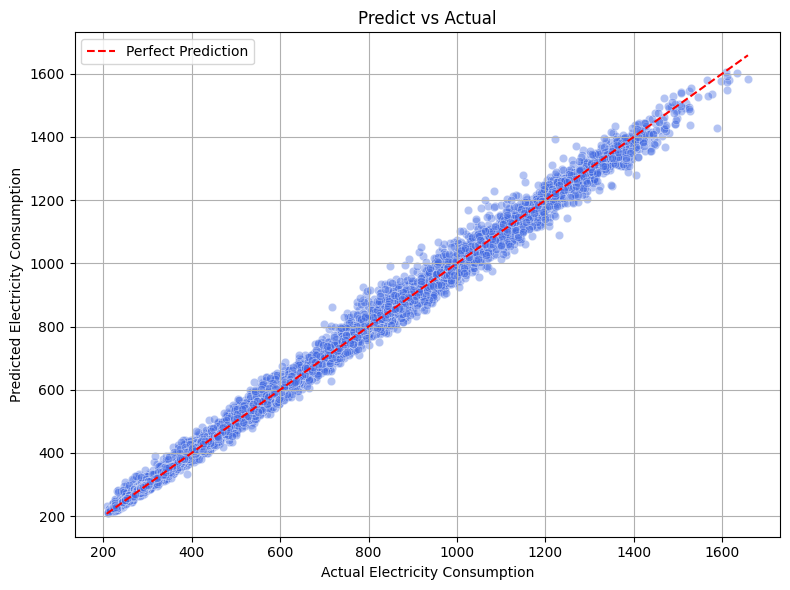


RMSE Rata-rata Validasi (5-Fold): 20.9019


In [12]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_scores = []
test_preds = []
fold = 1

val_preds_all = []
val_actuals_all = []

for train_idx, val_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # XGBoost
    xgb_model = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.015,
        max_depth=7,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        early_stopping_rounds=30,
        eval_metric='rmse',
        random_state=42
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    pred_val_xgb = xgb_model.predict(X_val)
    pred_test_xgb = xgb_model.predict(X_test)

    # LightGBM
    lgb_model = LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.01,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            early_stopping(stopping_rounds=100),
        ]
    )
    pred_val_lgb = lgb_model.predict(X_val)
    pred_test_lgb = lgb_model.predict(X_test)

    # Ensemble
    pred_val_ensemble = (pred_val_xgb + pred_val_lgb) / 2
    pred_test_ensemble = (pred_test_xgb + pred_test_lgb) / 2

    rmse = mean_squared_error(y_val, pred_val_ensemble, squared=False)
    val_scores.append(rmse)
    test_preds.append(pred_test_ensemble)
    print(f"RMSE Fold {fold}: {rmse:.4f}")
    fold += 1

    val_preds_all.extend(pred_val_ensemble)
    val_actuals_all.extend(y_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_actuals_all, y=val_preds_all, alpha=0.4, color='royalblue')
plt.plot([min(val_actuals_all), max(val_actuals_all)],
         [min(val_actuals_all), max(val_actuals_all)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Electricity Consumption')
plt.ylabel('Predicted Electricity Consumption')
plt.title('Predict vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hasil rata-rata
print(f"\nRMSE Rata-rata Validasi (5-Fold): {np.mean(val_scores):.4f}")


In [13]:
# Save model
xgb_model.save_model(f"/kaggle/working/model_xgb_final.json")
lgb_model.booster_.save_model(f"/kaggle/working/model_lgb_final.txt")

In [14]:
# Rerata prediksi test
final_test_pred = np.mean(test_preds, axis=0)

# Submission
submission = df_test[['ID']].copy()
submission['electricity_consumption'] = final_test_pred
submission.to_csv('/kaggle/working/submission_cv_ensemble.csv', index=False)